### St Michael Bay

**Station Name:**  at01

**Location:**  St Michael, Alaska

**Archive:**  [UNAVCO](http://www.unavco.org)

**Ellipsoidal Coordinates:**

- Latitude:  63.4840

- Longitude: -162.0064

- Height: 21.7 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/AT01)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/AT01.sta)

[Google Map Link](https://goo.gl/maps/uWyoNFf4DRjYLmfUA)

<p align="center">
<img src="https://www.unavco.org/data/gps-gnss/lib/images/station_images/AT01.jpg" width="500">
</p>

## Data Summary

at01 has good visibility over a large azimuthal region and the monument is about a meter taller than normal geodetic monuments which helps improve visibility of the sea surface. At01 observes all constellation signals.

## Imports

In [1]:
import os
import sys
import re
import json
import pandas as pd 
import numpy as np
import seaborn as sns; sns.set_theme(style="whitegrid");
import matplotlib.pyplot as plt
import datetime

# import gnssrefl functions
from gnssrefl.rinex2snr_cl import rinex2snr 
from gnssrefl.quickLook_cl import quicklook
from gnssrefl.make_json_input import make_json
from gnssrefl.gnssir_cl import gnssir
from gnssrefl.daily_avg_cl import daily_avg
from gnssrefl.subdaily_cl import subdaily

# We are including our repository bin to the system path so that we can import the following python modules
bin_path = os.path.abspath(os.path.join('../../bin'))
if bin_path not in sys.path:
    sys.path.append(bin_path)
    
import gnssrefl_helpers

%matplotlib inline

In [2]:
#Making sure environment variables are set - this is required to run the gnssrefl code
exists = gnssrefl_helpers.check_environment()
if exists == False:
    gnssrefl_helpers.set_environment()
        
refl_code_loc = os.environ['REFL_CODE']
# import the crx2rnx file which is dependant on your working OS - this is required to run the gnssrefl code
# If in docker environment, then you do not need to download crxnrnx
try:
    os.environ['DOCKER']
except KeyError:
    gnssrefl_helpers.download_crx2rnx()

environment variable ORBITS set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits 
environment variable REFL_CODE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter 
environment variable EXE set to path /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/bin/exe
downloading CRX2RNX file
file placed in path to execubles set by EXE environment variable
finished


In [3]:
# This is only for these use cases - you can set pltscreen=True in quicklook to print these plots as well
def pretty_plots(station, values, frequency, metrics=None):
    # plotting the quicklook graph periodograms
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,10), sharex=True)
    fig.suptitle(f'QuickLook: {station},{frequency}', size=16)

    quadrants = ['NW', 'NE', 'SW', 'SE']
    quadrant_labels = ['Northwest','Northeast', 'Southwest', 'Southeast']

    for i, ax in enumerate(axes.flat):
        quad = quadrants[i]
        for fail_satellite in values[f'f{quad}']:
            g = sns.lineplot(x=values[f'f{quad}'][fail_satellite][0],
                             y=values[f'f{quad}'][fail_satellite][1],
                             ax=ax, color='lightgrey')
        for satellite in values[quad]:
            g = sns.lineplot(x=values[quad][satellite][0],
                             y=values[quad][satellite][1],
                             ax=ax)
        g.set_title(quadrant_labels[i])
        g.set_ylabel('volts/volts')
        g.set_xlabel('reflector height (m)')

    if metrics:
        success, fail = gnssrefl_helpers.quicklook_metrics(metrics)
        fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)
        fig.suptitle(f'QuickLook Retrieval Metrics: {station}, {frequency}', size=16)

        for i, ax in enumerate(axes):
            g = sns.scatterplot(x='Azimuth',y=success.columns[i+1], data=success, ax=ax, label='good')
            g = sns.scatterplot(x='Azimuth',y=fail.columns[i+1], data=fail, ax=ax, color='lightgrey', label='bad')

        axes[0].legend(loc='upper right')

        avg_rh = np.mean(success['Reflector Height'])
        print(f'Average reflector height value: {avg_rh:.1f}')

    plt.tight_layout()
    plt.show()

# reflecion zone app

now we can use the reflection zone part of the web app:

In [ ]:
%%html
<iframe src="https://gnss-reflections.org/geoid" width="1000" height="600"></iframe>

Next, we could look at the reflection zone app to pick a possible mask.

In [ ]:
%%html
<iframe src="https://gnss-reflections.org/rzones" width="1000" height="700"></iframe>

just looking at this can give us an idea of the possible azimuth mask - Guessing we will not get good retrievals in the northwest quadrant. We will confirm this with the qc plots when we use quicklook.

It's also useful to note that it is about 12 meters above sea level.

### Take a Quick Look at the Data
First examine the spectral characteristics of the SNR data.

First, we download a snr file using rinex2snr. We will pick a year and day - in this case we'll look at day of year 109 for the year 2020. 

In [4]:
# Download SNR 
# we are going to just pick a year and day
# this will generate a SNR file at a sampling rate of 15 seconds.
station = 'at01'
year=2020
doy=109

rinex2snr(station=station, year=year, doy=doy, archive='unavco', orb='gnss')

Will seek the RINEX file externally
at01  year: 2020  doy: 109 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20201090000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/109/at011090.20d.Z
100% [..........................................................................] 3371029 / 3371029
 File has been found  at011090.20d.Z
SUCCESS at011090.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at011090.20.snr66
Feedback written to subdirectory logs


Now we can run quicklook, this is what it will look like if we don't change any of the defualts:

minimum elevation angle (degrees) for this dataset:  0.0011
Average reflector height value: 2.8


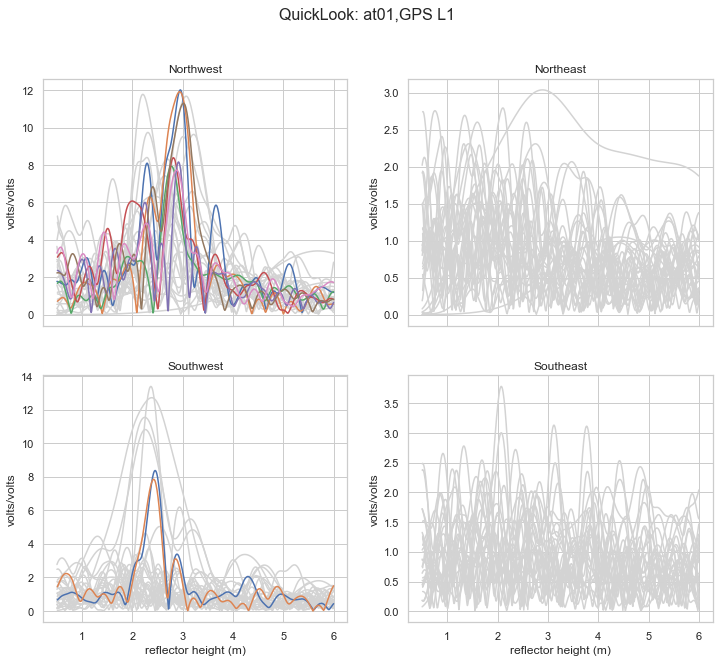

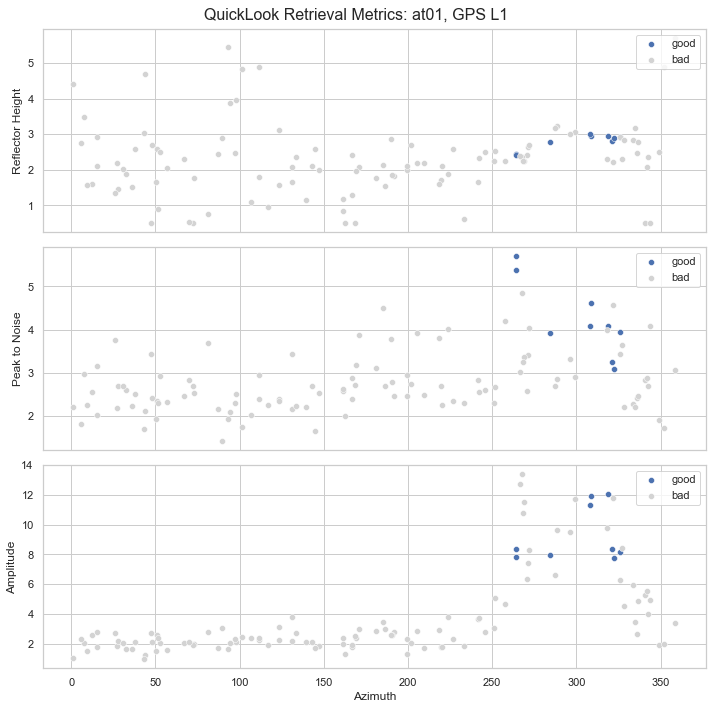

In [7]:
values, metrics = quicklook(station, year, doy=doy, pltscreen=False)
pretty_plots(station, values, 'GPS L1', metrics)

Using the default settings with quicklook we would likely think it is not a useful site, as nearly every retrieval is set as bad.

Let's see what the defaults are set to by adding a question mark to the function and running that cell.

In [ ]:
quicklook?

Now we can see what the defaults are and information about the parameters in the doc string as well. 

So, remembering that the site is 12 meters above sea level and we can see that the default restricts the reflector height region to 0.5 to 6 meters. 

Let's try quicklook again using a reflector height region that includes the water surface. We'll set h1 to 8 and h2 to 15 and we're also going to change the elevation angles to 5 and 13 degrees:

minimum elevation angle (degrees) for this dataset:  0.0011
Average reflector height value: 12.2


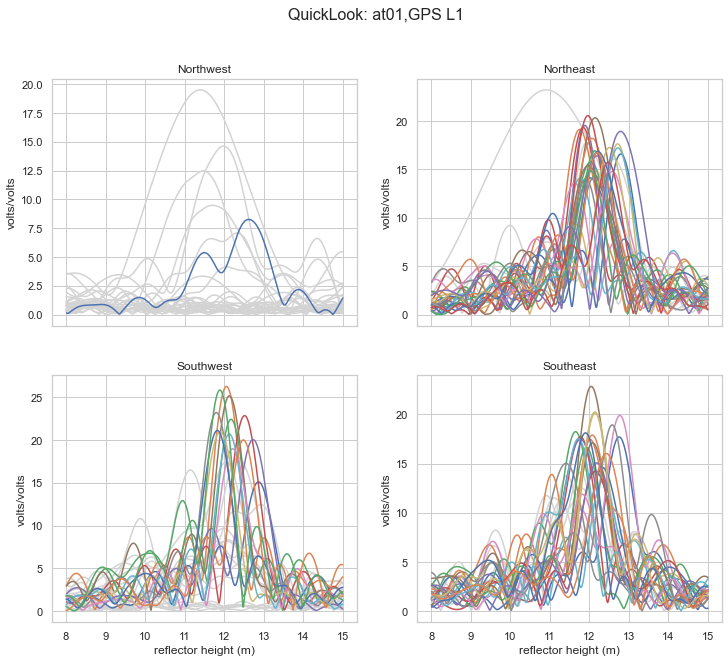

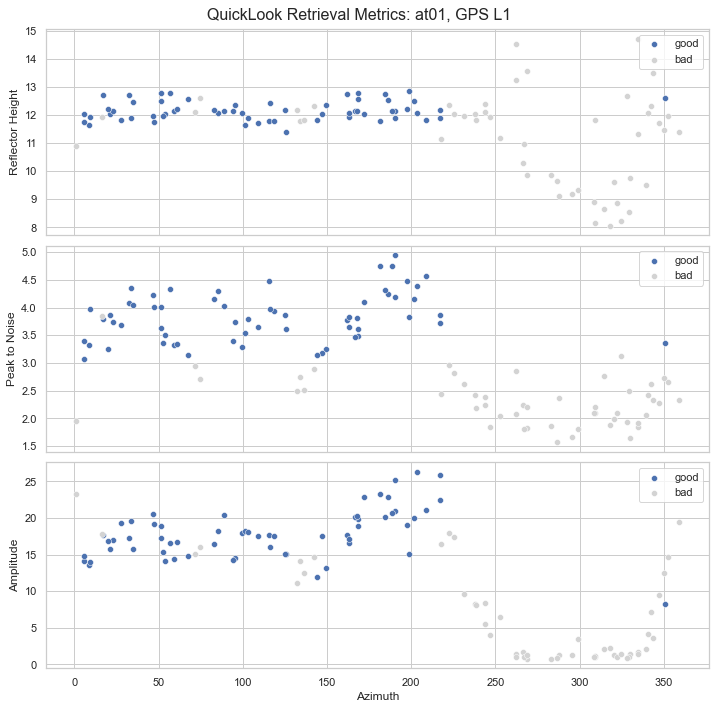

In [9]:
values, metrics = quicklook(station, year, doy=doy,
                                         e1=5, e2=13, h1=8, h2=15, pltscreen=False)

pretty_plots(station, values, 'GPS L1', metrics)

Now we see good retrievals at azimuths from true north to about 220 degrees (around what we expected from using the reflection zone app) and we also see strong retrievals in the Lomb Scargle periodograms.

This site does have modern GPS signals, as well as Galileo and Glonass signals.

results for L2C:

In [ ]:
values, metrics = quicklook(station, year, doy=doy, 
                                         e1=5, e2=13, h1=8, h2=15, f=20, pltscreen=False)

pretty_plots(station, values, 'GPS L2C')

Now we can look at glonass by setting f to 101 and Galileo we will set f to 205.

In [ ]:
values_l1, metrics_l1 = quicklook(station, year, doy=doy,
                                         e1=5, e2=13, h1=8, h2=15, f=101, pltscreen=False)

pretty_plots(station, values_l1, 'GLONASS')

values_l2, metrics_l2 = quicklook(station, year, doy=doy,
                                         e1=5, e2=13, h1=8, h2=15, f=205, pltscreen=False)

pretty_plots(station, values_l2, 'GALILEO')

### Analyze the Data

Next we will analyze data for two months in the fall of 2020. Our first step would be to make the SNR files.

In [12]:
rinex2snr?

In [10]:
rinex2snr(station, year, 230, doy_end=290, archive='unavco', orb='gnss')

Will seek the RINEX file externally
at01  year: 2020  doy: 230 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202300000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/230/at012300.20d.Z
100% [..........................................................................] 3242281 / 3242281
 File has been found  at012300.20d.Z
SUCCESS at012300.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012300.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 231 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202310000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/231/at012310.20d.Z
100% [..........................................................................] 3254535 / 3254535
 File has bee

Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202440000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/244/at012440.20d.Z
100% [..........................................................................] 3282585 / 3282585
 File has been found  at012440.20d.Z
SUCCESS at012440.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012440.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 245 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202450000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/245/at012450.20d.Z
100% [..........................................................................] 3305172 / 3305172
 File has been found  at012450.20d.Z
SUCCESS at012450.20o


SUCCESS: SNR file was created:

100% [..........................................................................] 3264372 / 3264372
 File has been found  at012580.20d.Z
SUCCESS at012580.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012580.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 259 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202590000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/259/at012590.20d.Z
100% [..........................................................................] 3273081 / 3273081
 File has been found  at012590.20d.Z
SUCCESS at012590.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012590.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 260 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/

 25% [..................                                                        ]  827392 / 3296113100% [..........................................................................] 3296113 / 3296113
 File has been found  at012720.20d.Z
SUCCESS at012720.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012720.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 273 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202730000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/273/at012730.20d.Z
100% [..........................................................................] 3273451 / 3273451
 File has been found  at012730.20d.Z
SUCCESS at012730.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012730.20.snr66
Will seek the RINEX file externally
at01  year: 

 30% [......................                                                    ] 1015808 / 3366146

100% [..........................................................................] 3366146 / 3366146
 File has been found  at012860.20d.Z
SUCCESS at012860.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012860.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 287 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/2020/sp3/GFZ0MGXRAP_20202870000_01D_05M_ORB.SP3
Searching the  unavco  archive for  at01
https://data.unavco.org/archive/gnss/rinex/obs/2020/287/at012870.20d.Z
100% [..........................................................................] 3233499 / 3233499
 File has been found  at012870.20d.Z
SUCCESS at012870.20o


SUCCESS: SNR file was created: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/snr/at01/at012870.20.snr66
Will seek the RINEX file externally
at01  year: 2020  doy: 288 from:  unavco
Orbit file:  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/orbits/

The next step is to create the json file that gnssir reads with the values that we have decided on from the quicklook step. In this case we will set the elevation angles and the heights. We will also set the parameter allfreq to true.

In [13]:
lat = 63.484
long = -162.006
height = 21.565

make_json(station, lat, long, height, e1=5, e2=13, h1=8, h2=15, allfreq=True)

writing out to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/at01.json


In [14]:
# This is the json file that was created with the defaults/parameters you set above
json_file = f'{refl_code_loc}/input/{station}.json'
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    
file

{'station': 'at01',
 'lat': 63.484,
 'lon': -162.006,
 'ht': 21.565,
 'minH': 8,
 'maxH': 15,
 'e1': 5,
 'e2': 13,
 'NReg': [8, 15],
 'PkNoise': 2.7,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [0, 90, 90, 180, 180, 270, 270, 360],
 'freqs': [1, 20, 5, 101, 102, 201, 205, 206, 207, 208, 302, 306],
 'reqAmp': [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': False,
 'pltname': 'at01_lsp.png',
 'delTmax': 75}

To set the azimuth range that we decided on, we need to edit the json file manually. We are also going to edit out the Beidou signals since they are not in rinex2 files.

In [15]:
# Now lets edit the json file
with open(json_file, "r") as myfile:
    file = json.load(myfile)
    
# Here is where we can 'hand edit' values in the json file
# lets edit the azimuths. We set these values by looking at the metrics qc plot above
file['azval'] = [20,90,90,180,180,220]
file['freqs'] = [1,20,5,101,102,201,205,206,207]
os.remove(json_file)

with open(json_file, 'w') as f:
    json.dump(file, f, indent=4)
    
# now lets view it again and note the difference
with open(json_file, "r") as myfile:
    file = json.load(myfile)

file

{'station': 'at01',
 'lat': 63.484,
 'lon': -162.006,
 'ht': 21.565,
 'minH': 8,
 'maxH': 15,
 'e1': 5,
 'e2': 13,
 'NReg': [8, 15],
 'PkNoise': 2.7,
 'polyV': 4,
 'pele': [5, 30],
 'ediff': 2,
 'desiredP': 0.005,
 'azval': [20, 90, 90, 180, 180, 220],
 'freqs': [1, 20, 5, 101, 102, 201, 205, 206, 207],
 'reqAmp': [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0],
 'refraction': True,
 'overwriteResults': True,
 'seekRinex': False,
 'wantCompression': False,
 'plt_screen': False,
 'onesat': None,
 'screenstats': False,
 'pltname': 'at01_lsp.png',
 'delTmax': 75}

Next, we will run gnssir to estimate the reflector height (RH) for the two month time period.

In [16]:
year = 2020
doy = 230
doy_end = 290
gnssir(station, year, doy, doy_end=doy_end, screenstats=False)

download and move refraction file
100% [........................................................................] 21773344 / 21773344A station specific refraction output file will be written to  /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/at01_refr.txt
The large refraction file should be stored here: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/input/gpt_1wA.pickle
station specific refraction file written
Results will be written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/at01//230.txt
Results will be written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/at01//231.txt
Results will be written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/at01//232.txt
Results will be written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/at01//233.txt
Results will be written to: /Users/enloe/UNAVCO_Projects/git/gnssrefl_jupyter/2020/results/at01//234.txt
Results will be written to: /Users/enloe/UNAVCO_P

We have do have some code to help you look at subdaily files. This will be helpful to look at tides. 

We will set an outlier criteria of 0.36 meters (one sigma 0.12 meters ==> 0.36 meters three sigma) to start with.

This preliminary version of the code removes outliers and makes an effort to compute the RH dot correction.

In [ ]:
tv, corr = subdaily(station='at01', year=2020, doy1=230, doy2=290,
                                 outlier=0.36, plt=True)